## LayoutLM, LayoutLMv2, LayoutLMv3 Model building and benchmarking

In this notebook, we are going to fine-tune different versions of LayoutLM models on CORD Dataset (https://github.com/clovaai/cord). The goal for the model is to label words appearing in scanned documents (namely, receipts) appropriately. This task is treated as a NER problem (sequence labeling). However, compared to BERT, LayoutLM family of models also incorporate visual and layout information about the tokens when encoding them into vectors.

Original Papers
#### LayoutLM :
* Paper: https://arxiv.org/pdf/1912.13318.pdf
* Original repo: https://github.com/microsoft/unilm/tree/master/layoutlm


#### LayoutLMv2 :
* Paper: https://arxiv.org/abs/2012.14740
* Original repo: https://github.com/microsoft/unilm/tree/master/layoutlmv2

#### LayoutLMV3 :
* Paper: https://arxiv.org/abs/2012.14740
* Original repo: https://github.com/microsoft/unilm/tree/master/layoutlmv3

#### Steps: 

* Understand the CORD Data
* Analyse the data
* Understand the OCR using Easy OCR
* Preprocess the data
* Build LayoutLM Model
* Build LayoutLMV2 Model
* Build LayoutLMV3 Model
* Benchmark the results

## Credits :

The notebook is inspired from the work of 
https://github.com/NielsRogge/Transformers-Tutorials and Huggingface

### Key Packages Installed
* Python 3.9 and transformers package
* Pillow is also used for images
* easyocr is used to show example of OCR
* cv2 ( not contrib) is used along with easyocr

In [1]:
# !conda create -n transformers python=3.9
# !pip install transformers[torch]
# !pip install tqdm
# !pip install Pillow
# !pip install opencv-python # NOTE: *not* opencv-contrib-python
# !pip install easyocr

## Import All Packages

In [22]:
### Base

import os
import random
from os.path import exists
from os import listdir
from tqdm import tqdm
#from tqdm.notebook import tqdm
import json
import pickle
import pandas as pd
from collections import Counter
import warnings
import numpy as np


### Images
from PIL import Image
from PIL import ImageDraw, ImageFont

### Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import torchvision
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage
from torchvision.ops import RoIAlign


### Transformers
from transformers import AdamW
from transformers import AutoProcessor

#LayoutLM
from transformers import LayoutLMTokenizer
from transformers import LayoutLMForTokenClassification
from transformers.models.layoutlm import LayoutLMModel, LayoutLMConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers import BertTokenizer



#LayoutLMV2
from transformers import LayoutLMv2ForTokenClassification
from transformers import LayoutLMv2Processor

#LayoutLMV3
from transformers import LayoutLMv3ForTokenClassification


### OCR
from easyocr import Reader
import cv2


### For Metrics for model evaluation
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)


warnings.filterwarnings("ignore")


### Data Download
The data is downlaoded from https://github.com/clovaai/cord

CORD: A Consolidated Receipt Dataset for Post-OCR Parsing
https://paperswithcode.com/paper/cord-a-consolidated-receipt-dataset-for-post

There are two folders in each of the train, dev and test.
* images: contains images
* json: contains annotations and ocr output

Set Paths :

In [63]:
train_path_json = '/home/rohit.walimbe/layoutlm_cord/train/json/'
val_path_json = '/home/rohit.walimbe/layoutlm_cord/dev/json/'
test_path_json = '/home/rohit.walimbe/layoutlm_cord/test/json/'

train_image_path = '/home/rohit.walimbe/layoutlm_cord/train/image/'
val_image_path = '/home/rohit.walimbe/layoutlm_cord/dev/image/'
test_image_path = '/home/rohit.walimbe/layoutlm_cord/test/image/'

## Visualise Images and Annotations

Let's have a look at various images from the training data. The data consists of various receipts images


Number of images and annotations available in each path :

In [64]:
image_paths = [train_image_path, val_image_path, test_image_path]
json_paths = [train_path_json, val_path_json, test_path_json]

print("Images : ")
for p in image_paths:
    print(p + " : " + str(len(os.listdir(p)) )) 
print("Annotations : ")   
for p in json_paths:
    print(p + " : " + str(len(os.listdir(p)) )) 

Images : 
/home/rohit.walimbe/layoutlm_cord/train/image/ : 745
/home/rohit.walimbe/layoutlm_cord/dev/image/ : 94
/home/rohit.walimbe/layoutlm_cord/test/image/ : 93
Annotations : 
/home/rohit.walimbe/layoutlm_cord/train/json/ : 787
/home/rohit.walimbe/layoutlm_cord/dev/json/ : 97
/home/rohit.walimbe/layoutlm_cord/test/json/ : 100


### Images

In [65]:

image = Image.open(train_image_path + 'receipt_00024.png')
image

### Annotations

Annotations consists of 
* words and numbers extracted from OCR engine 
* corresponding bounding boxes.
* labels associated with each of the extracted text

Lets check the annotations for same image.

In [66]:

with open(train_path_json+ '/receipt_00024.json') as json_file:
    data = json.load(json_file)
    
print(data.keys())
print(data['meta'])
print(len(data['valid_line']))

data

dict_keys(['dontcare', 'valid_line', 'meta', 'roi', 'repeating_symbol'])
{'version': 'v0.1', 'split': 'train', 'image_id': 24, 'image_size': {'width': 576, 'height': 864}}
15


{'dontcare': [],
 'valid_line': [{'words': [{'quad': {'x2': 152,
      'y3': 676,
      'x3': 152,
      'y4': 676,
      'x1': 92,
      'y1': 652,
      'x4': 92,
      'y2': 652},
     'is_key': 1,
     'row_id': 2146261,
     'text': 'Total.'},
    {'quad': {'x2': 467,
      'y3': 709,
      'x3': 465,
      'y4': 703,
      'x1': 390,
      'y1': 676,
      'x4': 388,
      'y2': 683},
     'is_key': 0,
     'row_id': 2146262,
     'text': '48.000'}],
   'category': 'total.total_price',
   'group_id': 21},
  {'words': [{'quad': {'x2': 146,
      'y3': 730,
      'x3': 146,
      'y4': 730,
      'x1': 92,
      'y1': 706,
      'x4': 92,
      'y2': 706},
     'is_key': 1,
     'row_id': 2146263,
     'text': 'Debet'},
    {'quad': {'x2': 194,
      'y3': 736,
      'x3': 191,
      'y4': 731,
      'x1': 148,
      'y1': 708,
      'x4': 146,
      'y2': 713},
     'is_key': 1,
     'row_id': 2146263,
     'text': 'Card'},
    {'quad': {'x2': 518,
      'y3': 775,
      'x3': 515

### Label Information
Below are the total labels available in the dataset

In [67]:

labels = ['menu.cnt',
 'menu.discountprice',
 'menu.etc',
 'menu.itemsubtotal',
 'menu.nm',
 'menu.num',
 'menu.price',
 'menu.sub_cnt',
 'menu.sub_etc',
 'menu.sub_nm',
 'menu.sub_price',
 'menu.sub_unitprice',
 'menu.unitprice',
 'menu.vatyn',
 'sub_total.discount_price',
 'sub_total.etc',
 'sub_total.othersvc_price',
 'sub_total.service_price',
 'sub_total.subtotal_price',
 'sub_total.tax_price',
 'total.cashprice',
 'total.changeprice',
 'total.creditcardprice',
 'total.emoneyprice',
 'total.menuqty_cnt',
 'total.menutype_cnt',
 'total.total_etc',
 'total.total_price',
 'void_menu.nm',
 'void_menu.price']

get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(labels))
print(colors)

['#f5a838', '#958d7c', '#baa6f8', '#2d356f', '#1bf2c7', '#14e6a9', '#746720', '#b5a474', '#d420e9', '#84f1e4', '#5efadf', '#e16b1d', '#f825af', '#3915ce', '#8f8fa2', '#2e973a', '#21b04b', '#6942d1', '#45b204', '#8d9dec', '#1085d0', '#0539ef', '#86d331', '#d48e3c', '#9f0066', '#38b711', '#226786', '#1b6001', '#b5b396', '#456bc3']


### Draw Image
Now for the same image and annotation, lets try to plot the bounding boxes on image  

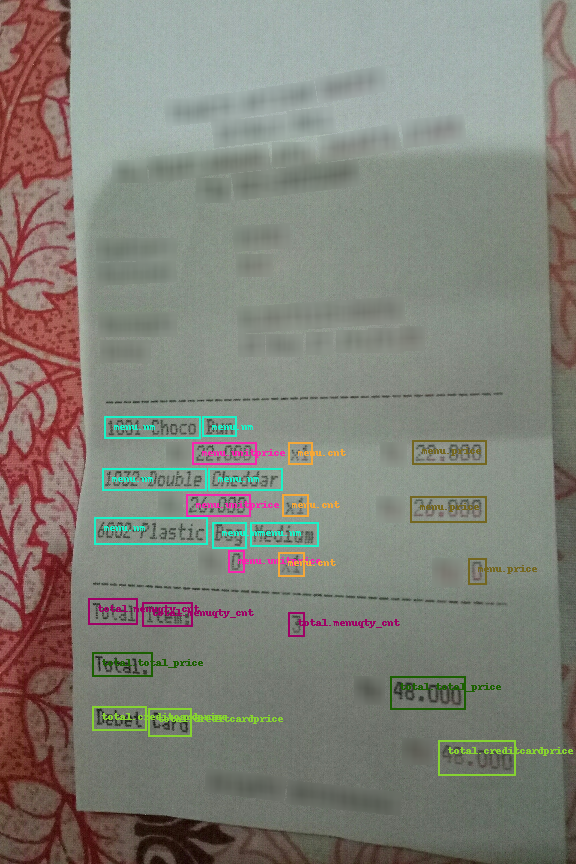

In [68]:

draw = ImageDraw.Draw(image, "RGBA")

#font = ImageFont.load_default()
font = ImageFont.load_default()

label2color = {label: colors[idx] for idx, label in enumerate(labels)}

for annotation in data['valid_line']:
    label = annotation['category']
    words = annotation['words']
    for word in words:
        coordinates = word['quad']
        x1, y1 = coordinates['x1'], coordinates['y1']
        x3, y3 = coordinates['x3'], coordinates['y3']
        box = [x1, y1, x3, y3]
        draw.rectangle(box, outline=label2color[label], width=2)
        draw.text((box[0]+10, box[1]+5), label, fill=label2color[label], font=font)

image

## How to generate above data for our own use case
As we can see from above example, each bounding box in the receipt has been annotated with OCR extract and bounding box and has label associated with it. In practice, generating such data till this step can be time consuming. 

Let's assume that we dont have above annotated data handy. In that case we can use our own OCR as long as it gives us bounding boxes and text. Some of the choices we have are :
* Easy OCR
* Tesseract ( used by LayoutLM )
* DoctR , etc

Once we have Text and Bounding boxes ready, we can use any annotation tool of our choise which has OCR annotation availability to label the bounding boxes with classes

Below is the example of Easy OCR



In [69]:
image = cv2.imread(train_image_path + 'receipt_00024.png')
# OCR the input image using EasyOCR
reader = Reader(['en'])
results = reader.readtext(image)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [70]:
# loop over the results
for (bbox, text, prob) in results:
    # display the OCR'd text and associated probability
    print('text : ', text,'\nprobability : ', prob,'\nbounding box : ', bbox , '\n---')
    # unpack the bounding box
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))
    # cleanup the text and draw the box surrounding the text along
    # with the OCR'd text itself
    #text = cleanup_text(text)
    cv2.rectangle(image, tl, br, (0, 255, 0), 2)
    cv2.putText(image, text, (tl[0], tl[1] - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
# show the output image
#cv2.imshow("Image", image)


text :  1001-Choco Bun 
probability :  0.9133167235358443 
bounding box :  [[104, 414], [238, 414], [238, 438], [104, 438]] 
---
text :  22.00D 
probability :  0.3913127865467818 
bounding box :  [[192, 440], [256, 440], [256, 466], [192, 466]] 
---
text :  22.000 
probability :  0.451391564678675 
bounding box :  [[412, 440], [486, 440], [486, 464], [412, 464]] 
---
text :  1032-Double Cheddar 
probability :  0.9110657919214 
bounding box :  [[100, 466], [282, 466], [282, 490], [100, 490]] 
---
text :  26.O0D 
probability :  0.39639184312456144 
bounding box :  [[184, 492], [250, 492], [250, 518], [184, 518]] 
---
text :  xi 
probability :  0.523682512085958 
bounding box :  [[281, 497], [305, 497], [305, 517], [281, 517]] 
---
text :  26.000 
probability :  0.5646147408513815 
bounding box :  [[410, 494], [486, 494], [486, 520], [410, 520]] 
---
text :  6002-Plastic Bag Hedium 
probability :  0.5304597865038961 
bounding box :  [[94, 518], [318, 518], [318, 548], [94, 548]] 
---
text

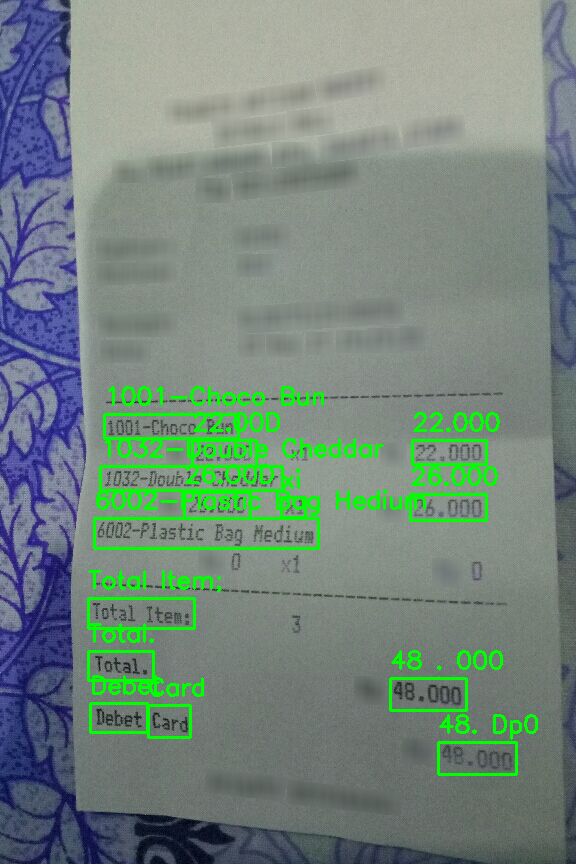

In [71]:
PIL_image = Image.fromarray(image.astype('uint8'), 'RGB')
PIL_image

### STEP 1 : Prepare Data set

Now let's come back to our data which is already annotated

We will start writing functions to parse json files and prepare data which can be fed to the models.

The same train test val data will be fed to 3 models which are LayoutLM, LayoutLMv2, LayoutLMv3

We will write a single function **generate_annotations** which reads json file and creates the list for 

1- Extracted words

2- Bounding Boxes

3- Normalised bounding boxes

4- Lables

5- Image names to keep track to which image this list belongs to 

##### Important  : I have used only 300 training images from training data and 100 for val and test so that notebook can be run in today's session easily.


### Check JSON

In [73]:
### We need to normalise the bounding box co-ordinates for Layout LM
def normalize_bbox(bbox, width, height):
     return [
         int(1000 * (bbox[0] / width)),
         int(1000 * (bbox[1] / height)),
         int(1000 * (bbox[2] / width)),
         int(1000 * (bbox[3] / height)),
     ]



def generate_annotations(path: str, im_path : str):
    image_name = []
    if 'train' in path : 
        
        annotation_files = []
        for js in tqdm(os.listdir(path)[0:300]): ## Used 300 for training
            with open(path + js) as f:
                json_name = path+js
                image_name_ = im_path + json_name.split('/')[-1].split('.')[0] + '.png'
                file_exists = exists(image_name_)
                if file_exists :
                    annotation_files.append(json.load(f))
                    image_name.append(image_name_)
    else:
        annotation_files = []
        for js in tqdm(os.listdir(path)[0:100]): # Used 100 for train and test
            with open(path + js) as f:
                json_name = path+js
                image_name_ = im_path + json_name.split('/')[-1].split('.')[0] + '.png'
                file_exists = exists(image_name_)
                if file_exists :
                    annotation_files.append(json.load(f))
                    image_name.append(image_name_)   
    words = []
    boxes = []
    un_boxes = []
    labels = []
    
    for js in tqdm(annotation_files):
        words_example = []
        boxes_example = []
        un_box_example = []
        labels_example = []

        width, height = js['meta']['image_size']['width'], js['meta']['image_size']['height']
      # loop over OCR annotations
        for elem in js['valid_line']:
            for word in elem['words']:
                # get word
                txt = word['text']
                # get bounding box
                # important: each bounding box should be in (upper left, lower right) format
                # it was confusing to understand the upper left is (x1, y3)
                # and the lower right is (x3, y1)
                x1 = word['quad']['x1']
                y1 = word['quad']['y1']
                x3 = word['quad']['x3']
                y3 = word['quad']['y3']

                box = [x1, y1, x3, y3]
                un_box = box
                box = normalize_bbox(box, width=width, height=height)
                
                # ADDED
                # skip empty word
                if len(txt) < 1: 
                    continue
                if min(box) < 0 or max(box) > 1000: # another bug in which a box had -4
                    continue
                if ((box[3] - box[1]) < 0) or ((box[2] - box[0]) < 0): # another bug in which a box difference was -12
                    continue
                # ADDED

                words_example.append(txt)
                boxes_example.append(box) 
                un_box_example.append(un_box) 
                labels_example.append(elem['category'])
        words.append(words_example) 
        boxes.append(boxes_example)
        un_boxes.append(un_box_example)
        labels.append(labels_example)
  
    return words, boxes, un_boxes, labels,image_name


In [74]:

words_train, boxes_train,un_boxes_train, labels_train, image_names_train = generate_annotations(train_path_json, train_image_path)
words_val, boxes_val,un_boxes_val, labels_val, image_names_val = generate_annotations(val_path_json, val_image_path)
words_test, boxes_test,un_boxes_test, labels_test,image_names_test = generate_annotations(test_path_json, test_image_path)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 13181.17it/s]


In [77]:
print(len(words_train))
#words_train[1]
labels_train[1]
#image_names_train

279


['menu.cnt',
 'menu.nm',
 'menu.nm',
 'menu.price',
 'menu.unitprice',
 'total.total_price',
 'total.total_price',
 'total.total_price',
 'total.cashprice',
 'total.cashprice',
 'total.changeprice',
 'total.changeprice',
 'sub_total.subtotal_price',
 'sub_total.subtotal_price',
 'sub_total.subtotal_price']

One observation is the actual data is lesser than 300 and 100 images selected earlier . this is due to some annotations are missing in downloaded data

### Inspect Labels

We can now check the count of each label and decide if we want use all the labels. For today's session, I have decided to remove some of the labels which have low occurence. This decision depends on every business problem

In [78]:
all_labels = [item for sublist in labels_train for item in sublist] + [item for sublist in labels_val for item in sublist] + [item for sublist in labels_test for item in sublist]

pd.DataFrame.from_dict(Counter(all_labels), orient='index').reset_index().sort_values(by = 0)

index     0
22                menu.vatyn     3
24                  menu.etc     4
23         menu.itemsubtotal     6
20                  menu.num    37
9            total.total_etc    48
21         total.emoneyprice    67
15        total.menutype_cnt    68
18            menu.sub_price    73
16              menu.sub_cnt    80
14  sub_total.discount_price    84
11             sub_total.etc   148
12   sub_total.service_price   162
13     total.creditcardprice   183
19        menu.discountprice   213
10         total.menuqty_cnt   309
8             menu.unitprice   320
17               menu.sub_nm   377
2          total.changeprice   600
7        sub_total.tax_price   607
1            total.cashprice   659
6   sub_total.subtotal_price   689
0          total.total_price   998
3                   menu.cnt  1082
5                 menu.price  1190
4                    menu.nm  3029

In [79]:

labels_to_replace  = list(pd.DataFrame.from_dict(Counter(all_labels), orient='index').reset_index().sort_values(by = 0)['index'])[0:9]

replacing_labels = {}

for lab in labels_to_replace: 
    replacing_labels[lab] = 'O'
print(replacing_labels)  
#replacing_labels = {'menu.etc': 'O', 'menu.itemsubtotal': 'O', 'menu.sub_etc': 'O', 'menu.sub_unitprice': 'O', 'menu.vatyn': 'O',
#                  'void_menu.nm': 'O', 'void_menu.price': 'O', 'sub_total.othersvc_price': 'O'}


{'menu.vatyn': 'O', 'menu.etc': 'O', 'menu.itemsubtotal': 'O', 'menu.num': 'O', 'total.total_etc': 'O', 'total.emoneyprice': 'O', 'total.menutype_cnt': 'O', 'menu.sub_price': 'O', 'menu.sub_cnt': 'O'}


In [80]:
def replace_elem(elem):
    try:
        return replacing_labels[elem]
    except KeyError:
        return elem
def replace_list(ls):
    return [replace_elem(elem) for elem in ls]
labels_train = [replace_list(ls) for ls in labels_train]
labels_val = [replace_list(ls) for ls in labels_val]
labels_test = [replace_list(ls) for ls in labels_test]


all_labels = [item for sublist in labels_train for item in sublist] + [item for sublist in labels_val for item in sublist] + [item for sublist in labels_test for item in sublist]
Counter(all_labels)

Counter({'total.total_price': 998,
         'total.cashprice': 659,
         'total.changeprice': 600,
         'menu.cnt': 1082,
         'menu.nm': 3029,
         'menu.price': 1190,
         'sub_total.subtotal_price': 689,
         'sub_total.tax_price': 607,
         'menu.unitprice': 320,
         'O': 386,
         'total.menuqty_cnt': 309,
         'sub_total.etc': 148,
         'sub_total.service_price': 162,
         'total.creditcardprice': 183,
         'sub_total.discount_price': 84,
         'menu.sub_nm': 377,
         'menu.discountprice': 213})

#### Let's save the pickle files of annotations for easy access later

In [81]:
with open('/home/rohit.walimbe/layoutlm_cord/train.pkl', 'wb') as t:
    pickle.dump([words_train, labels_train, boxes_train,un_boxes_train, image_names_train], t)
with open('/home/rohit.walimbe/layoutlm_cord/dev.pkl', 'wb') as t:
    pickle.dump([words_val, labels_val, boxes_val, un_boxes_val,image_names_val], t)
with open('/home/rohit.walimbe/layoutlm_cord/test.pkl', 'wb') as t:
    pickle.dump([words_test, labels_test, boxes_test, un_boxes_test, image_names_test], t)


# Modelling

Once we have the pickle file sready, lets read them and start creating the data which will be used in different model


In [82]:
### Read Pickels
train = pd.read_pickle('/home/rohit.walimbe/layoutlm_cord/train.pkl')
val = pd.read_pickle('/home/rohit.walimbe/layoutlm_cord/dev.pkl')
test = pd.read_pickle('/home/rohit.walimbe/layoutlm_cord/test.pkl')

We will need to create indices of lables so that thos e will be later used in model and analysing results later. 

We will create 2 lists label2id and id2label 

Let's keep these 2 lists common for all 3 models 

In [83]:
labels = list(set(all_labels))
print('Total Labels : ', len(labels)) 
print(labels)

label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}
print(label2id)
print(id2label)

Total Labels :  17
['menu.price', 'menu.nm', 'sub_total.service_price', 'menu.sub_nm', 'total.total_price', 'total.creditcardprice', 'menu.discountprice', 'sub_total.subtotal_price', 'total.changeprice', 'total.cashprice', 'O', 'menu.unitprice', 'sub_total.discount_price', 'sub_total.tax_price', 'sub_total.etc', 'menu.cnt', 'total.menuqty_cnt']
{'menu.price': 0, 'menu.nm': 1, 'sub_total.service_price': 2, 'menu.sub_nm': 3, 'total.total_price': 4, 'total.creditcardprice': 5, 'menu.discountprice': 6, 'sub_total.subtotal_price': 7, 'total.changeprice': 8, 'total.cashprice': 9, 'O': 10, 'menu.unitprice': 11, 'sub_total.discount_price': 12, 'sub_total.tax_price': 13, 'sub_total.etc': 14, 'menu.cnt': 15, 'total.menuqty_cnt': 16}
{0: 'menu.price', 1: 'menu.nm', 2: 'sub_total.service_price', 3: 'menu.sub_nm', 4: 'total.total_price', 5: 'total.creditcardprice', 6: 'menu.discountprice', 7: 'sub_total.subtotal_price', 8: 'total.changeprice', 9: 'total.cashprice', 10: 'O', 11: 'menu.unitprice', 12

### Some important functions to be used later

Results evaluation :

In [84]:
def results_test(preds, out_label_ids, labels):
    ## Takes predictions, outlabel ids and labels as input
    ## Output is Classification Report
    preds = np.argmax(preds, axis=2)

    label_map = {i: label for i, label in enumerate(labels)}

    out_label_list = [[] for _ in range(out_label_ids.shape[0])]
    preds_list = [[] for _ in range(out_label_ids.shape[0])]

    for i in range(out_label_ids.shape[0]):
        for j in range(out_label_ids.shape[1]):
            if out_label_ids[i, j] != -100:
                out_label_list[i].append(label_map[out_label_ids[i][j]])
                preds_list[i].append(label_map[preds[i][j]])

    results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
    return results, classification_report(out_label_list, preds_list, suffix = True)

Resize corresponding bounding boxes (annotations) :

In [85]:
# Credits : https://stackoverflow.com/questions/49466033/resizing-image-and-its-bounding-box
## Based on image resizing, resize the bounding boxes as well
def resize_and_align_bounding_box(bbox, original_image, target_size):
    x_, y_ = original_image.size

    x_scale = target_size / x_ 
    y_scale = target_size / y_

    origLeft, origTop, origRight, origBottom = tuple(bbox)

    x = int(np.round(origLeft * x_scale))
    y = int(np.round(origTop * y_scale))
    xmax = int(np.round(origRight * x_scale))
    ymax = int(np.round(origBottom * y_scale)) 
  
    
    return [x-0.5, y-0.5, xmax+0.5, ymax+0.5]




## Layout LM Model

Key Features:
* Pretraining of text+layout is separate 
* Text+Layout and Visual features combined in final fine-tuning stage of model
* The layout LM model is BERT + Bounding Box 2D Positions as layout and Visual features through CNN as one single model


In this step we will write a class CORDDataset_LayoutLM

**__getitem__** will take the indices from batch and perform below steps 

* Read Image
* Resize the image to 224 x 224
* Read the words, labels and bounding boxes
* Transform above lists token-level
* Truncate the sequence if legth is higher than max_seq_length
* Read image and resize it convert everything to pytorch tensor

In [87]:

class CORDDataset_LayoutLM(Dataset):
    """LayoutLM dataset with visual features."""

    def __init__(self, annotations,image_dir, base_path, tokenizer, max_length, target_size, train=True):
        #self.image_file_names = image_file_names
        self.words, self.labels, self.boxes, self.un_boxes, self.image_names = annotations
        self.image_dir = image_dir
        self.base_path = base_path
        self.image_file_names = self.image_names #[f for f in listdir(image_dir)]
        self.tokenizer = tokenizer
        self.max_seq_length = max_length
        self.target_size = target_size
        self.pad_token_box = [0, 0, 0, 0]
        self.train = train

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):

        ### 1- Take index and read the image
        item = self.image_file_names[idx]
        base_path = self.base_path
        
        original_image = Image.open(item).convert("RGB")
        
        # 2- resize to target size (to be provided to the pre-trained backbone)
        resized_image = original_image.resize((self.target_size, self.target_size))
        
        # 3- For thes ame index : read in annotations at word-level (words, bounding boxes, labels)
        words = self.words[idx]
        word_labels = self.labels[idx]
        normalized_word_boxes = self.boxes[idx]
        unnormalized_word_boxes=self.un_boxes[idx]

        
        # 4- transform to token-level (input_ids, attention_mask, token_type_ids, bbox, labels)
        token_boxes = []
        unnormalized_token_boxes = []
        token_labels = []
        for word, unnormalized_box, box, label in zip(words, unnormalized_word_boxes, normalized_word_boxes, word_labels):
            ## Tokenise the words
            word_tokens = self.tokenizer.tokenize(word)
            ## for each of those word token , get the unnormalized_box
            unnormalized_token_boxes.extend(unnormalized_box for _ in range(len(word_tokens)))
            ## for each of the word token , get the normalised box
            token_boxes.extend(box for _ in range(len(word_tokens)))
            # Prepare label tokens
            for i in range(len(word_tokens)):
                token_labels.extend([label])
        
        # Truncation of token_boxes + token_labels. If the token length is gereater than 512 the truncate the sequence
        special_tokens_count = 2 
        if len(token_boxes) > self.max_seq_length - special_tokens_count:
            token_boxes = token_boxes[: (self.max_seq_length - special_tokens_count)]
            unnormalized_token_boxes = unnormalized_token_boxes[: (self.max_seq_length - special_tokens_count)]
            token_labels = token_labels[: (self.max_seq_length - special_tokens_count)]
        
        # In case of the tokens like cls + sep : add bounding boxes and labels as -100
        token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]
        unnormalized_token_boxes = [[0, 0, 0, 0]] + unnormalized_token_boxes + [[1000, 1000, 1000, 1000]]
        token_labels = [-100] + token_labels + [-100]
        
        encoding = self.tokenizer(' '.join(words), padding='max_length', truncation=True)
        # Padding of token_boxes up the bounding boxes to the sequence length.
        input_ids = self.tokenizer(' '.join(words), truncation=True)["input_ids"]
        padding_length = self.max_seq_length - len(input_ids)
        token_boxes += [self.pad_token_box] * padding_length
        unnormalized_token_boxes += [self.pad_token_box] * padding_length
        token_labels += [-100] * padding_length
        encoding['bbox'] = token_boxes
        encoding['labels'] = token_labels

        assert len(encoding['input_ids']) == self.max_seq_length
        assert len(encoding['attention_mask']) == self.max_seq_length
        assert len(encoding['token_type_ids']) == self.max_seq_length
        assert len(encoding['bbox']) == self.max_seq_length
        assert len(encoding['labels']) == self.max_seq_length

        
        #####
        ## Once tokenisation is done, also read the image , resize it along with bounding boxes
        encoding['resized_image'] = ToTensor()(resized_image)
        # rescale and align the bounding boxes to match the resized image size (typically 224x224) 
        encoding['resized_and_aligned_bounding_boxes'] = [resize_and_align_bounding_box(bbox, original_image, self.target_size) 
                                                          for bbox in unnormalized_token_boxes]

        encoding['unnormalized_token_boxes'] = unnormalized_token_boxes
        
        # finally, convert everything to PyTorch tensors 
        for k,v in encoding.items():
            if k == 'labels':
                label_indices = []
              # convert labels from string to indices
                for label in encoding[k]:
                    if label != -100:
                        label_indices.append(label2id[label])
                    else:
                        label_indices.append(label)
                    encoding[k] = label_indices
            encoding[k] = torch.as_tensor(encoding[k])
        
        return encoding

### Read the bert tokeniser

In [88]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [89]:

train_dataset = CORDDataset_LayoutLM(annotations=train,
                            image_dir='/home/rohit.walimbe/layoutlm_cord/train/image/', 
                            tokenizer=tokenizer,
                            base_path = '/home/rohit.walimbe/layoutlm_cord/train',
                            max_length=512, target_size=224)
val_dataset = CORDDataset_LayoutLM(annotations=val,
                            image_dir='/home/rohit.walimbe/layoutlm_cord/dev/image/', 
                            tokenizer=tokenizer,
                            base_path = '/home/rohit.walimbe/layoutlm_cord/train',
                            max_length=512,
                            target_size=224)
test_dataset = CORDDataset_LayoutLM(annotations=test,
                            image_dir='/home/rohit.walimbe/layoutlm_cord/test/image/', 
                            tokenizer=tokenizer,
                            base_path = '/home/rohit.walimbe/layoutlm_cord/train',
                            max_length=512, target_size=224)

In [90]:
train_dataset[0]

{'input_ids': tensor([  101,  2561,  1024,  4466,  1010, 25604,  5356,  1024,  2531,  1010,
         2199,  2689,  1024,  4868,  1010, 25897,  1015,  2000, 16213,  5643,
         7221, 25923,  3366,  2654,  1010, 17691,  1015, 25043, 12486, 13675,
        13699,  2229,  2321,  1010,  3429,  2629,  4942,  3406,  9080,  1024,
         4724,  1010,  6191,  2581,  1052,  2497,  2487,  1024,  1018,  1010,
         4029,  2549,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

DataLoader will be used to load data in batches

In [91]:

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [92]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k, batch[k].shape)

input_ids torch.Size([4, 512])
token_type_ids torch.Size([4, 512])
attention_mask torch.Size([4, 512])
bbox torch.Size([4, 512, 4])
labels torch.Size([4, 512])
resized_image torch.Size([4, 3, 224, 224])
resized_and_aligned_bounding_boxes torch.Size([4, 512, 4])
unnormalized_token_boxes torch.Size([4, 512, 4])


In [93]:
encoding = train_dataset[0]
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'labels', 'resized_image', 'resized_and_aligned_bounding_boxes', 'unnormalized_token_boxes'])

In [94]:
tokenizer.decode(encoding.input_ids)

'[CLS] total : 48, 001 cash : 100, 000 change : 51, 999 1 toblerone bancheese 28, 182 1 roast beef crepes 15, 455 subtotal : 43, 637 pb1 : 4, 364 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

Let's visually  check the resizing has worked fine for the images

In [95]:
test_image = ToPILImage()(encoding['resized_image']).convert("RGB")
test_image

In [96]:
draw = ImageDraw.Draw(test_image, "RGBA")
for bbox in encoding['resized_and_aligned_bounding_boxes'].tolist():
    draw.rectangle(bbox, outline='red', width=1)

test_image

In [97]:
class LayoutLMForTokenClassification(nn.Module):
    def __init__(self, output_size=(3,3), 
                 spatial_scale=14/224, 
                 sampling_ratio=2
        ): 
        super().__init__()
        
        # LayoutLM base model + token classifier
        # Get number of labels
        self.num_labels = len(label2id)
        # Get the pretrained layoutlm model
        self.layoutlm = LayoutLMModel.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=self.num_labels)
        # Get the classifier
        self.dropout = nn.Dropout(self.layoutlm.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.layoutlm.config.hidden_size, self.num_labels)

        print(self.layoutlm.config.hidden_size)
        # backbone + roi-align + projection layer
        # Get the resent model
        model = torchvision.models.resnet101(pretrained=True)
        self.backbone = nn.Sequential(*(list(model.children())[:-3]))
        ## RoIAlign is an operation for extracting a small feature map from each RoI in detection and segmentation based tasks
        self.roi_align = RoIAlign(output_size, spatial_scale=spatial_scale, sampling_ratio=sampling_ratio)
        self.projection = nn.Linear(in_features=1024*3*3, out_features=self.layoutlm.config.hidden_size)

    def forward(
        self,
        input_ids,
        bbox,
        attention_mask,
        token_type_ids,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        resized_images=None, # shape (N, C, H, W), with H = W = 224
        resized_and_aligned_bounding_boxes=None, # single torch tensor that also contains the batch index for every bbox at image size 224
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.

        """
        return_dict = return_dict if return_dict is not None else self.layoutlm.config.use_return_dict

        # first, forward pass on LayoutLM
        outputs = self.layoutlm(
            input_ids=input_ids,
            bbox=bbox,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        
        #print(sequence_output.shape) sequence_output
        #shape of output is (batch_size, 512, 768)

        # next, send resized images of shape (batch_size, 3, 224, 224) through backbone to get feature maps of images 
        # shape (batch_size, 1024, 14, 14)
        feature_maps = self.backbone(resized_images)
        
        # next, use roi align to get feature maps of individual (resized and aligned) bounding boxes
        # shape (batch_size*seq_len, 1024, 3, 3)
        device = input_ids.device
        resized_bounding_boxes_list = []
        for i in resized_and_aligned_bounding_boxes:
            resized_bounding_boxes_list.append(i.float().to(device))

        
        feat_maps_bboxes = self.roi_align(input=feature_maps, 
                                        # we pass in a list of tensors
                                        # We have also added -0.5 for the first two coordinates and +0.5 for the last two coordinates,
                                        rois=resized_bounding_boxes_list
                           )  
      
        # The  projected_feat_maps_bboxes which has size of  (batch_size, seq_len, hidden_size) is finally used in the 
        # next, reshape  + project to same dimension as LayoutLM. 
        batch_size = input_ids.shape[0]
        seq_len = input_ids.shape[1]
        feat_maps_bboxes = feat_maps_bboxes.view(batch_size, seq_len, -1) # Shape (batch_size, seq_len, 1024*3*3)
        projected_feat_maps_bboxes = self.projection(feat_maps_bboxes) # Shape (batch_size, seq_len, hidden_size)

        # add those to the sequence_output - shape (batch_size, seq_len, hidden_size)
        # in this step add the image image features to sequence image
        sequence_output += projected_feat_maps_bboxes

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        ### Swrite a final loss function for classification of the labels and bounding box
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()

            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)[active_loss]
                active_labels = labels.view(-1)[active_loss]
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [98]:
model = LayoutLMForTokenClassification()

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing LayoutLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


768


`num_train_epochs is selected as 1 for demo purpose`

In [99]:

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#put the model in training mode
model.to(device)
model.train()
for epoch in range(num_train_epochs):
    print("Epoch:", epoch)
    for batch in tqdm(train_dataloader):
        # forward pass
        # For each batch :
        # Get the Input IDs
        input_ids=batch['input_ids'].to(device) ## Size (batchsize, max_length)
        bbox=batch['bbox'].to(device) ## Size (batchsize, max_length, 4)
        attention_mask=batch['attention_mask'].to(device) ## Size (batchsize, max_length)
        token_type_ids=batch['token_type_ids'].to(device) ## Size (batchsize, max_length)
        labels=batch['labels'].to(device) ## Size (batchsize, max_length)
        resized_images = batch['resized_image'].to(device) ## Size ([batchsize, 3, 224, 224])
        resized_and_aligned_bounding_boxes = batch['resized_and_aligned_bounding_boxes'].to(device) ## Size (batchsize, max_length, 4)

        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids, 
                      labels=labels, resized_images=resized_images, resized_and_aligned_bounding_boxes=resized_and_aligned_bounding_boxes)
        loss = outputs.loss

        # print loss every 10 steps
        if global_step % 10 == 0:
            print(f"Loss after {global_step} steps: {loss.item()}")

        # backward pass to get the gradients 
        loss.backward()
        # update
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
        
        
#model.save_pretrained("/home/rohit.walimbe/layoutlm_cord/Checkpoints/layoutlm")

Epoch: 0


  0%|                                                                                                                                                                                                            | 0/70 [00:00<?, ?it/s]

Loss after 0 steps: 2.767373561859131


 14%|███████████████████████████▊                                                                                                                                                                       | 10/70 [01:14<07:26,  7.45s/it]

Loss after 10 steps: 1.7870731353759766


 29%|███████████████████████████████████████████████████████▋                                                                                                                                           | 20/70 [02:30<06:20,  7.60s/it]

Loss after 20 steps: 1.6371967792510986


 43%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 30/70 [03:45<05:03,  7.59s/it]

Loss after 30 steps: 1.5401403903961182


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 40/70 [05:00<03:43,  7.44s/it]

Loss after 40 steps: 0.3600093722343445


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 50/70 [06:14<02:29,  7.47s/it]

Loss after 50 steps: 0.5344533324241638


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 60/70 [07:28<01:14,  7.40s/it]

Loss after 60 steps: 0.6107144951820374


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [08:40<00:00,  7.44s/it]


### LayoutLM Evaluation
Once Our Model is ready, Lets evaluate the model on test data.

On the test data we have created earler, we apply same steps of batches on test_dataloader

In [100]:
preds_val = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(test_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids=batch['input_ids'].to(device)
        bbox=batch['bbox'].to(device)
        attention_mask=batch['attention_mask'].to(device)
        token_type_ids=batch['token_type_ids'].to(device)
        labels=batch['labels'].to(device)
        resized_images = batch['resized_image'].to(device) 
        resized_and_aligned_bounding_boxes = batch['resized_and_aligned_bounding_boxes'].to(device) 

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids, 
                        labels=labels, resized_images=resized_images, resized_and_aligned_bounding_boxes=resized_and_aligned_bounding_boxes)
        
        if preds_val is None:
            preds_val = outputs.logits.detach().cpu().numpy()
            out_label_ids = batch["labels"].detach().cpu().numpy()
        else:

            preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0

          )
            


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:47<00:00,  1.97s/it]


In [101]:
val_result, class_report = results_test(preds_val, out_label_ids, list(set(all_labels)))
print("Overall results:", val_result)
print(class_report)

Overall results: {'precision': 0.7360902255639098, 'recall': 0.8282571912013537, 'f1': 0.7794585987261148}
                         precision    recall  f1-score   support

                menu.cn       0.76      0.95      0.84       212
      menu.discountpric       0.07      0.10      0.08        10
                 menu.n       0.69      0.85      0.76       235
              menu.pric       0.86      0.98      0.91       231
             menu.sub_n       0.50      0.13      0.21        30
          menu.unitpric       0.91      0.97      0.94        65
sub_total.discount_pric       0.00      0.00      0.00         7
           sub_total.et       0.05      0.12      0.07         8
 sub_total.service_pric       0.00      0.00      0.00        12
sub_total.subtotal_pric       0.85      0.79      0.82        67
     sub_total.tax_pric       0.48      0.65      0.56        46
         total.cashpric       0.78      0.78      0.78        65
       total.changepric       0.61      0.78   

## LAYOUTLM_V2
Now that we have peliminary results for LayoutLM features, 

To quickly revise key features of the LayoutLMv2 Model :
* Pretraining of visual( CNN ) and text and layout information is together
* 2-D relative position representation for token pairs
* Text-image alignment strategy and text-image matching strategy
* Cross-modal interaction end to-end in a single framework
* Spatial-aware self-attention mechanism
* Masking of text and corresponding part of image


#### Get the processor

Constructs a LayoutLMv2 processor which combines a LayoutLMv2 feature extractor and a LayoutLMv2 tokenizer into a
single processor.

[`LayoutLMv2Processor`] offers all the functionalities you need to prepare data for the model.

It first uses [`LayoutLMv2FeatureExtractor`] to resize document images to a fixed size, and optionally applies OCR
to get words and normalized bounding boxes. These are then provided to [`LayoutLMv2Tokenizer`] or
[`LayoutLMv2TokenizerFast`], which turns the words and bounding boxes into token-level `input_ids`,
`attention_mask`, `token_type_ids`, `bbox`. Optionally, one can provide integer `word_labels`, which are turned
into token-level `labels` for token classification tasks (such as FUNSD, CORD).

In [11]:
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

In [43]:
class CORDDataset_LayoutLMv2(Dataset):
    """CORD dataset."""

    def __init__(self, annotations, image_dir, processor=None, max_length=512):
        """
        Args:
            annotations (List[List]): List of lists containing the word-level annotations (words, labels, boxes).
            image_dir (string): Directory with all the document images.
            processor (LayoutLMv2Processor): Processor to prepare the text + image.
        """
        self.words, self.labels, self.boxes,self.un_boxes, self.image_names = annotations
        self.image_dir = image_dir
        self.image_file_names = self.image_names #[f for f in listdir(image_dir)]
        self.processor = processor

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        # first, take an image
        item = self.image_file_names[idx]
        image = Image.open(item).convert("RGB") #Image.open(self.image_dir + item).convert("RGB")

        # get word-level annotations 
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        assert len(words) == len(boxes) == len(word_labels)
        
        word_labels = [label2id[label] for label in word_labels]
        # use processor to prepare everything
        encoded_inputs = self.processor(image, words, boxes=boxes, word_labels=word_labels, 
                                        padding="max_length", truncation=True, 
                                        return_tensors="pt")
        
        # remove batch dimension
        for k,v in encoded_inputs.items():
            encoded_inputs[k] = v.squeeze()

        assert encoded_inputs.input_ids.shape == torch.Size([512])
        assert encoded_inputs.attention_mask.shape == torch.Size([512])
        assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs

In [50]:


train_dataset = CORDDataset_LayoutLMv2(annotations=train,
                            image_dir='/home/rohit.walimbe/layoutlm_cord/train/image/', 
                            processor=processor)
val_dataset = CORDDataset_LayoutLMv2(annotations=val,
                            image_dir='/home/rohit.walimbe/layoutlm_cord/dev/image/', 
                            processor=processor)
test_dataset = CORDDataset_LayoutLMv2(annotations=test,
                            image_dir='/home/rohit.walimbe/layoutlm_cord/test/image/', 
                            processor=processor)

In [51]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8)

Let's check the output

In [52]:
encoding = train_dataset[0]
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'labels', 'image'])

In [53]:
train_dataset[0]

{'input_ids': tensor([  101,  2561,  1024,  4466,  1010, 25604,  5356,  1024,  2531,  1010,
         2199,  2689,  1024,  4868,  1010, 25897,  1015,  2000, 16213,  5643,
         7221, 25923,  3366,  2654,  1010, 17691,  1015, 25043, 12486, 13675,
        13699,  2229,  2321,  1010,  3429,  2629,  4942,  3406,  9080,  1024,
         4724,  1010,  6191,  2581,  1052,  2497,  2487,  1024,  1018,  1010,
         4029,  2549,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [54]:
for k,v in encoding.items():
    print(k, v.shape)

input_ids torch.Size([512])
token_type_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])
image torch.Size([3, 224, 224])


In [55]:
print(processor.tokenizer.decode(encoding['input_ids']))

[CLS] total : 48, 001 cash : 100, 000 change : 51, 999 1 toblerone bancheese 28, 182 1 roast beef crepes 15, 455 subtotal : 43, 637 pb1 : 4, 364 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

We can verify how preprocessor is assigning the labels to inpiut ids

In [56]:
for id, label in zip(encoding['input_ids'][:30], encoding['labels'][:30]):
    print(processor.tokenizer.decode([id]), label.item())

[CLS] -100
total 4
: -100
48 4
, -100
001 -100
cash 9
: -100
100 9
, -100
000 -100
change 8
: -100
51 8
, -100
999 -100
1 15
to 1
##bler -100
##one -100
ban 1
##chee -100
##se -100
28 0
, -100
182 -100
1 15
roast 1
beef 1
cr 1


In [57]:
model = LayoutLMv2ForTokenClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',
                                                                      num_labels=len(label2id))

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res3.3.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.2.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.0.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.4.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.4.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.13.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.19.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.2.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.3.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.16.conv2.norm.num_batches_tracked'

Some weights of LayoutLMv2ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 1

#put the model in training mode
model.train() 
for epoch in range(num_train_epochs):  
    print("Epoch:", epoch)
    for batch in tqdm(train_dataloader):
        #print(batch)
        # get the inputs;
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        image=image,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels) 
        loss = outputs.loss
        
        # print loss every 100 steps
        if global_step % 10 == 0:
            print(f"Loss after {global_step} steps: {loss.item()}")

        loss.backward()
        optimizer.step()
        global_step += 1

#model.save_pretrained("/home/rohit.walimbe/layoutlm_cord/Checkpoints/layoutlmv2")

Epoch: 0


  0%|                                                                                                                                                                                                            | 0/35 [00:00<?, ?it/s]

Loss after 0 steps: 2.0340616703033447


 29%|███████████████████████████████████████████████████████▋                                                                                                                                           | 10/35 [02:04<05:12, 12.50s/it]

Loss after 10 steps: 1.7894861698150635


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 20/35 [04:09<03:06, 12.46s/it]

Loss after 20 steps: 1.7107607126235962


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 30/35 [06:12<01:01, 12.32s/it]

Loss after 30 steps: 1.5754661560058594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [07:13<00:00, 12.39s/it]


Check the Prediction :

We can also quickly check how we can predict the output for only one single image

In [61]:
encoding = test_dataset[0]
processor.tokenizer.decode(encoding['input_ids'])

for k,v in encoding.items():
    encoding[k] = v.unsqueeze(0).to(device)

model.eval()
# forward pass
outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'],
                token_type_ids=encoding['token_type_ids'], bbox=encoding['bbox'],
                image=encoding['image'])

prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()


prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()
print(len(prediction_indices))
predictions = [id2label[label] for gt, label in zip(encoding['labels'].squeeze().tolist(), prediction_indices) if gt != -100]
print(predictions)

512
['menu.cnt', 'menu.nm', 'menu.nm', 'menu.nm', 'menu.price', 'menu.cnt', 'menu.nm', 'menu.nm', 'menu.nm', 'menu.price', 'total.total_price', 'total.total_price', 'total.cashprice', 'total.cashprice', 'total.changeprice', 'total.changeprice']


We will use test dataloader for evaluation

In [62]:

preds_val = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(test_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, 
                        token_type_ids=token_type_ids, labels=labels)
        
        if preds_val is None:
            preds_val = outputs.logits.detach().cpu().numpy()
            out_label_ids = batch["labels"].detach().cpu().numpy()
        else:
            preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0
          )

Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:52<00:00,  4.37s/it]


In [ ]:

val_result, class_report = results_test(preds_val, out_label_ids, list(set(all_labels)))
print("Overall results:", val_result)
print(class_report)

## LayoutLMv3

* Directly leverages raw image patches from document images
* Does not rely on a pre-trained CNN or Faster R-CNN backbone to extract visual features
* Word-Patch Alignment (WPA) objective to facilitate cross-modal alignment learning
* Unified discrete token reconstructive objectives MLM and MIM - Masked Language Modelling , Masked Image Modelling
* General-purpose model for both text-centric and image-centric Document AI tasks.

It first uses [`LayoutLMv3FeatureExtractor`] to resize and normalize document images, and optionally applies OCR to
get words and normalized bounding boxes. These are then provided to [`LayoutLMv3Tokenizer`] or
[`LayoutLMv3TokenizerFast`], which turns the words and bounding boxes into token-level `input_ids`,
`attention_mask`, `token_type_ids`, `bbox`. Optionally, one can provide integer `word_labels`, which are turned
into token-level `labels` for token classification tasks (such as FUNSD, CORD).

In [72]:
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [73]:

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:


class CORDDatasetLayoutLMV3(Dataset):
    """CORD dataset."""

    def __init__(self, annotations, image_dir, processor=None, max_length=512):
        """
        Args:
            annotations (List[List]): List of lists containing the word-level annotations (words, labels, boxes).
            image_dir (string): Directory with all the document images.
            processor (LayoutLMv2Processor): Processor to prepare the text + image.
        """
        self.words, self.labels, self.boxes,self.un_boxes, self.image_names  = annotations
        self.image_dir = image_dir
        self.image_file_names = self.image_names #[f for f in listdir(image_dir)]
        self.processor = processor

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        # first, take an image
        item = self.image_file_names[idx]
        #image = Image.open(self.image_dir + item).convert("RGB")
        image = Image.open(item).convert("RGB")

        # get word-level annotations 
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        assert len(words) == len(boxes) == len(word_labels)
        
        word_labels = [label2id[label] for label in word_labels]
        # use processor to prepare everything
        encoded_inputs = self.processor(image, words, boxes=boxes, word_labels=word_labels, 
                                        padding="max_length", truncation=True, 
                                        return_tensors="pt")
        # remove batch dimension
        for k,v in encoded_inputs.items():
            encoded_inputs[k] = v.squeeze()

        assert encoded_inputs.input_ids.shape == torch.Size([512])
        assert encoded_inputs.attention_mask.shape == torch.Size([512])
        assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        assert encoded_inputs.pixel_values.shape == torch.Size([3, 224, 224])
        assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs

In [75]:
train_dataset = CORDDatasetLayoutLMV3(annotations=train,
                            image_dir='/home/rohit.walimbe/layoutlm_cord/train/image/', 
                            processor=processor)
val_dataset = CORDDatasetLayoutLMV3(annotations=val,
                            image_dir='/home/rohit.walimbe/layoutlm_cord/dev/image/', 
                            processor=processor)
test_dataset = CORDDatasetLayoutLMV3(annotations=test,
                            image_dir='/home/rohit.walimbe/layoutlm_cord/test/image/', 
                            processor=processor)

In [76]:

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [77]:
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 1

#put the model in training mode
model.train() 
for epoch in range(num_train_epochs):  
    print("Epoch:", epoch)
    for batch in tqdm(train_dataloader):
        #print(batch)
        # get the inputs;
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        pixel_values=pixel_values,
                        attention_mask=attention_mask,
                        labels=labels) 
        loss = outputs.loss
        
        # print loss every 10 steps
        if global_step % 10 == 0:
            print(f"Loss after {global_step} steps: {loss.item()}")

        loss.backward()
        optimizer.step()
        global_step += 1

#model.save_pretrained("/home/rohit.walimbe/layoutlm_cord/Checkpoints/layoutlmv3")

Epoch: 0


  0%|                                                                                                                                                                                                            | 0/70 [00:00<?, ?it/s]

Loss after 0 steps: 2.808565378189087


 14%|███████████████████████████▊                                                                                                                                                                       | 10/70 [01:17<07:49,  7.83s/it]

Loss after 10 steps: 2.576683759689331


 29%|███████████████████████████████████████████████████████▋                                                                                                                                           | 20/70 [02:35<06:28,  7.76s/it]

Loss after 20 steps: 1.881574034690857


 43%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 30/70 [03:53<05:14,  7.87s/it]

Loss after 30 steps: 1.4515377283096313


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 40/70 [05:12<03:52,  7.76s/it]

Loss after 40 steps: 1.2772257328033447


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 50/70 [06:30<02:33,  7.68s/it]

Loss after 50 steps: 1.083011269569397


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 60/70 [07:47<01:18,  7.83s/it]

Loss after 60 steps: 1.1661720275878906


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [09:05<00:00,  7.80s/it]


In [78]:

preds_val = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(test_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, pixel_values=pixel_values, attention_mask=attention_mask, 
                        labels=labels)
        
        if preds_val is None:
            preds_val = outputs.logits.detach().cpu().numpy()
            out_label_ids = batch["labels"].detach().cpu().numpy()
        else:
            preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0

          )  

val_result, class_report = results_test(preds_val, out_label_ids, list(set(all_labels)))
print("Overall results:", val_result)
print(class_report)


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [01:02<00:00,  2.62s/it]

Overall results: {'precision': 0.7303459119496856, 'recall': 0.7859560067681896, 'f1': 0.7571312143439284}
                         precision    recall  f1-score   support

                menu.cn       0.83      0.95      0.89       212
      menu.discountpric       0.38      0.30      0.33        10
                 menu.n       0.75      0.91      0.82       235
              menu.pric       0.88      0.96      0.92       231
             menu.sub_n       0.00      0.00      0.00        30
          menu.unitpric       0.88      0.82      0.85        65
sub_total.discount_pric       0.00      0.00      0.00         7
           sub_total.et       0.00      0.00      0.00         8
 sub_total.service_pric       0.00      0.00      0.00        12
sub_total.subtotal_pric       0.70      0.64      0.67        67
     sub_total.tax_pric       0.36      0.50      0.42        46
         total.cashpric       0.49      0.63      0.55        65
       total.changepric       0.49      0.76   

## Single Image Prediction :

In [81]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

encoding = test_dataset[0]

for k,v in encoding.items():
    encoding[k] = v.unsqueeze(0).to(device)

model.eval()
# forward pass
outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'], bbox=encoding['bbox'],
                pixel_values=encoding['pixel_values'])

prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()


predictions = outputs.logits.argmax(-1).squeeze().tolist()
labels = encoding.labels.squeeze().tolist()



token_boxes = encoding.bbox.squeeze().tolist()
image = Image.open(test[4][0])
width, height = image.size

true_predictions = [id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]


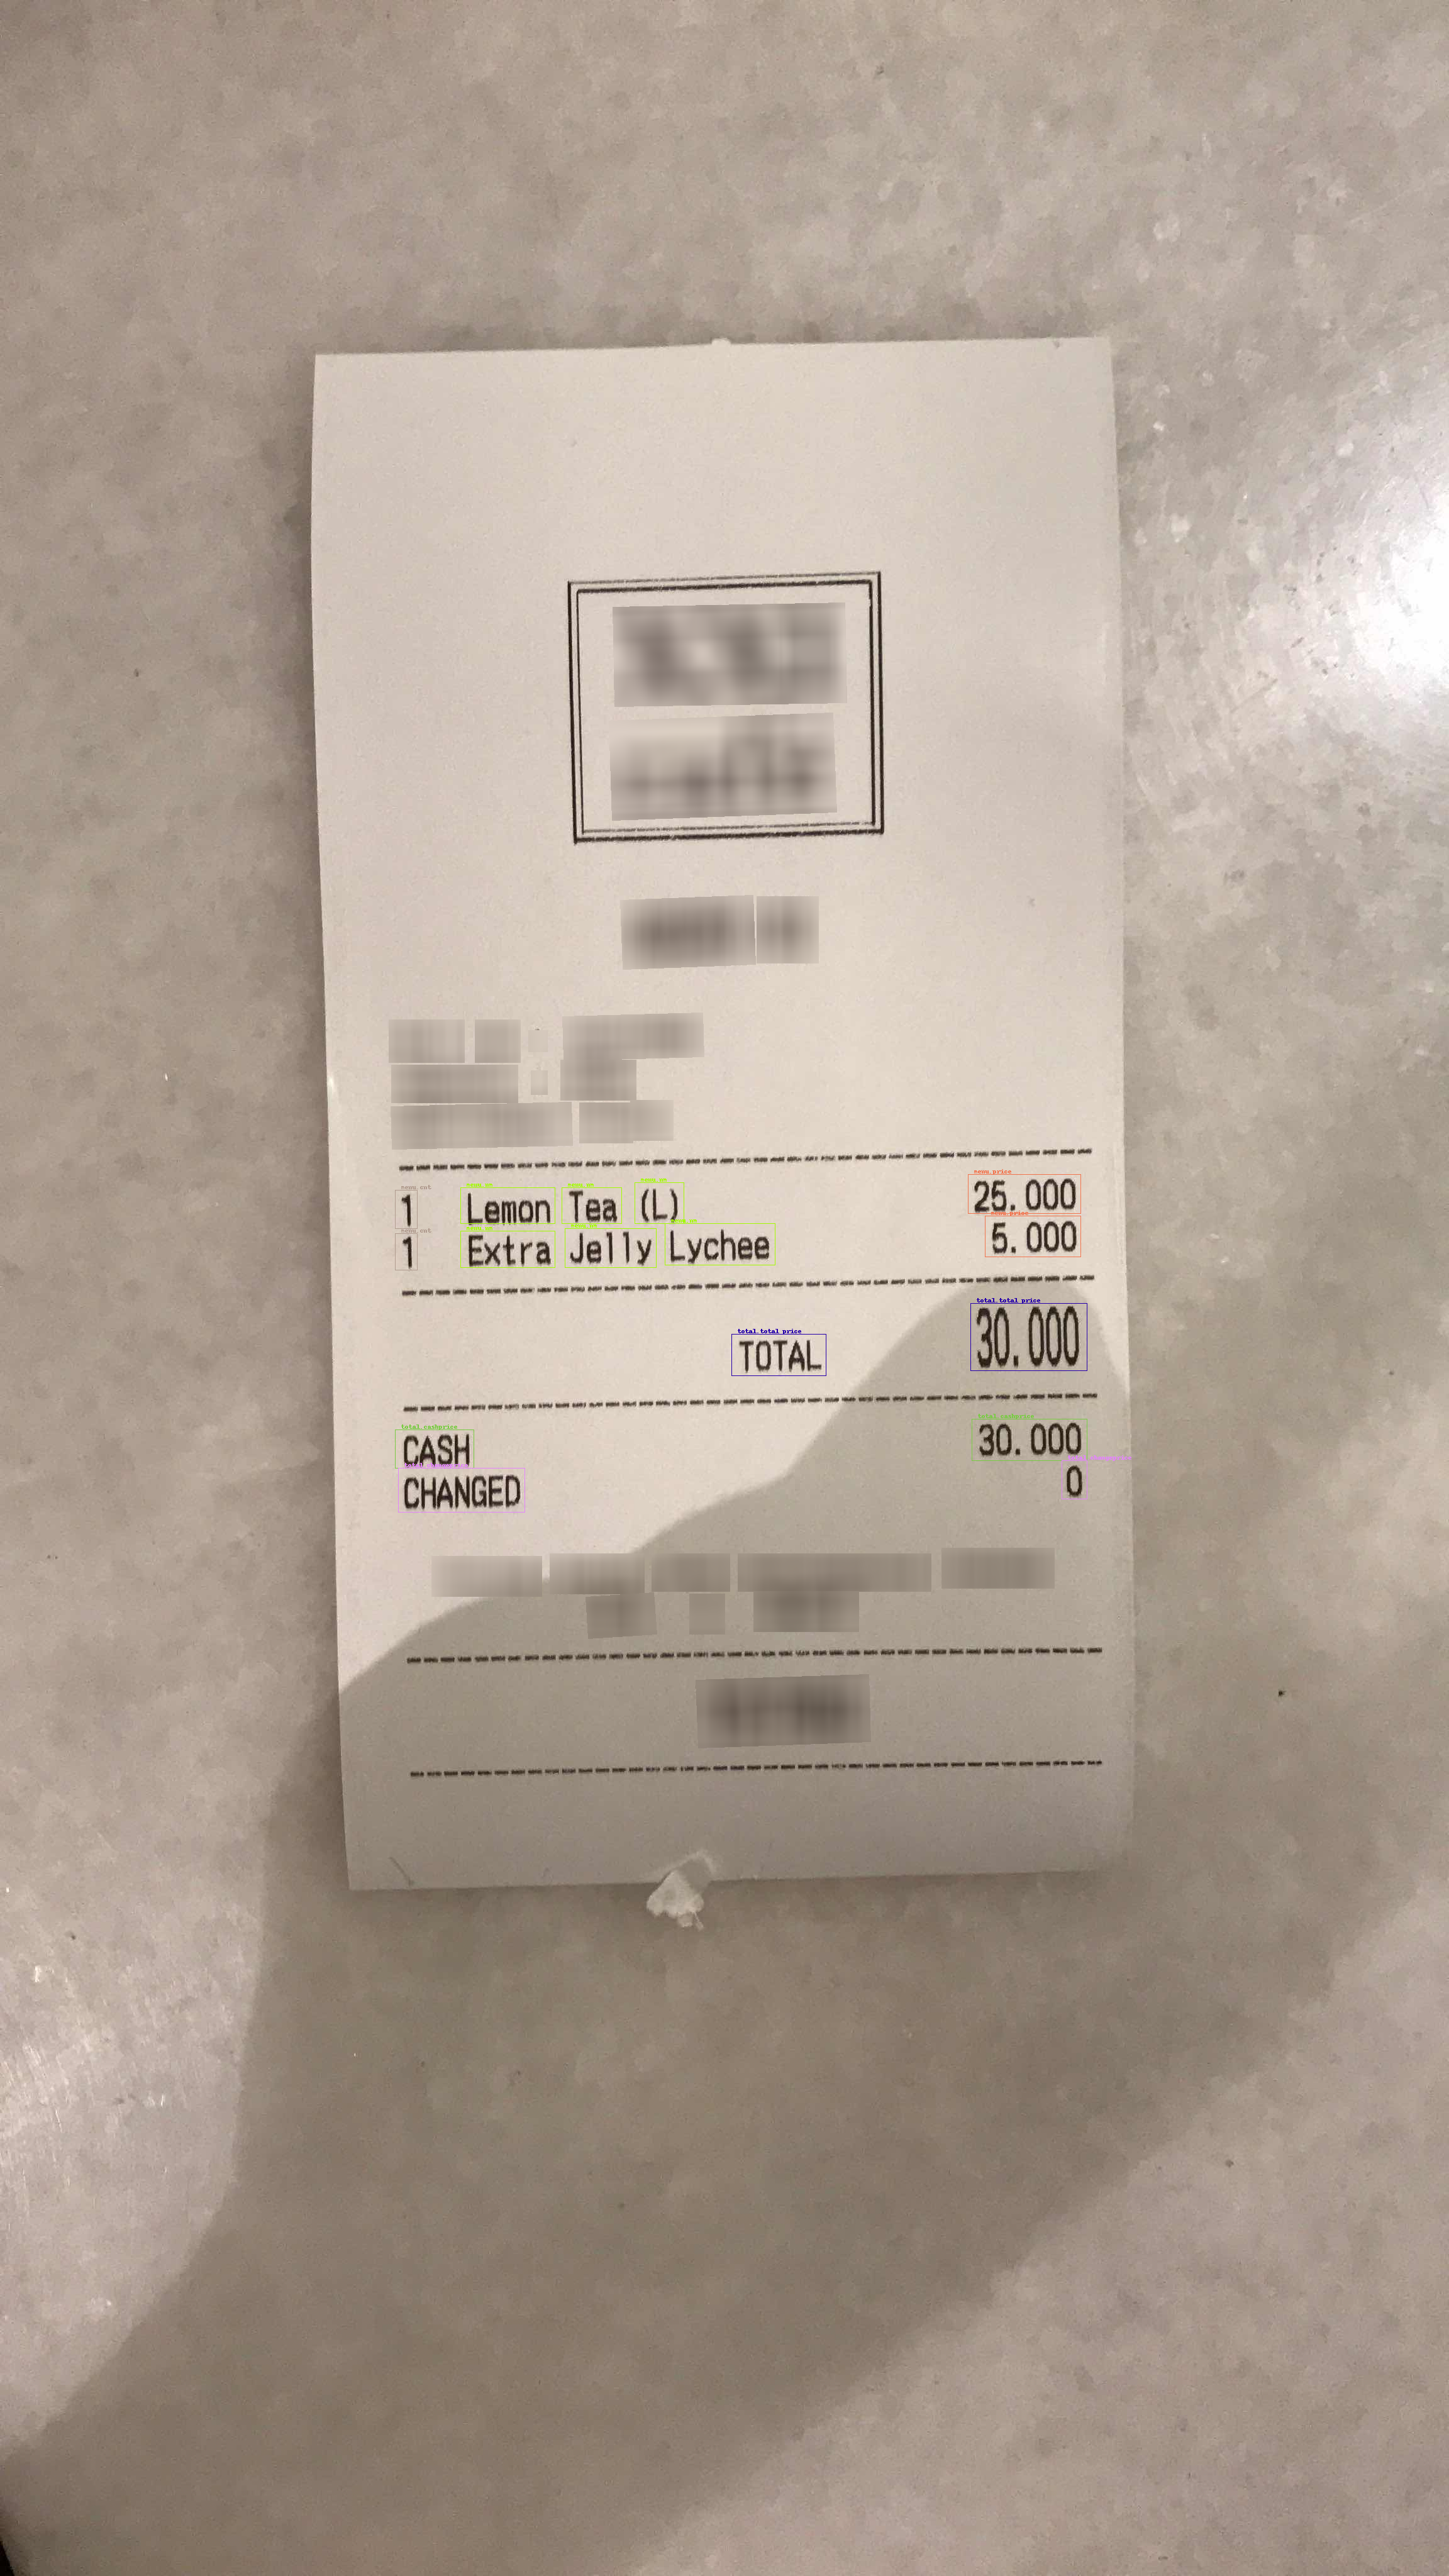

In [82]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = prediction.lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

## Results on Higher EPOCHS :

**LayoutLM**

`Overall results: {'precision': 0.8704663212435233, 'recall': 0.8842105263157894, 'f1': 0.877284595300261}`

**LayoutLMv2**

`Overall results: {'precision': 0.8822495606326889, 'recall': 0.8807017543859649, 'f1': 0.8814749780509218}`

**LayoutLMv3**

`Overall results: {'precision': 0.9074410163339383, 'recall': 0.8771929824561403, 'f1': 0.8920606601248884}`